# Suggestion de Tags - Approche supervisée

#### Divers: Imports, options

In [1]:
# suppression des "FutureWarning"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import scipy

In [3]:
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [4]:
pd.set_option('display.max_columns', 20)

## Chargement Données

In [5]:
df = pd.read_csv("questions_clean.csv", index_col=0)

In [6]:
tokenizer = nltk.RegexpTokenizer(r'[<>]', gaps=True)
df['Tags_tok'] = df['Tags'].map(tokenizer.tokenize)

In [7]:
df['Tags_tok']

0                    [java, arrays, java-14, java-record]
1               [google-chrome, graphics, macos-catalina]
2       [amazon-web-services, amazon-ec2, amazon-rds, ...
3       [python, tensorflow, keras, google-colaborator...
4                           [powershell, powershell-core]
                              ...                        
8064                                       [java, gradle]
8065                    [spring-webflux, project-reactor]
8066            [c++, templates, struct, padding, memcmp]
8067                     [kubernetes, kubernetes-ingress]
8068                                      [linux, docker]
Name: Tags_tok, Length: 8069, dtype: object

In [8]:
def gotAnyTags(x, tags):
    return any(elem in x for elem in tags)

def gotAllTags(x, tags):
    return all(elem in x for elem in tags)

def getSubsetForAnyTags(tags):
    return df[df['Tags_tok'].apply(lambda x : gotAnyTags(x, tags))]

def getSubsetForAllTags(tags):
    return df[df['Tags_tok'].apply(lambda x : gotAllTags(x, tags))]

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

def showWordCloud(tags=None, allTags=False):
    if tags is not None:
        if type(tags) is list:
            if allTags:
                subset = getSubsetForAllTags(tags)
            else:
                subset = getSubsetForAnyTags(tags)
        else:
            subset = getSubsetForAnyTags([tags])
        text = subset["Text"].values
    else:
        text = df["Text"].values

    print("Number of docs:", len(text))
    print("Tags:", tags)

    long_string = ','.join(list(text))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=800, height=400)
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud

Number of docs: 8069
Tags: None


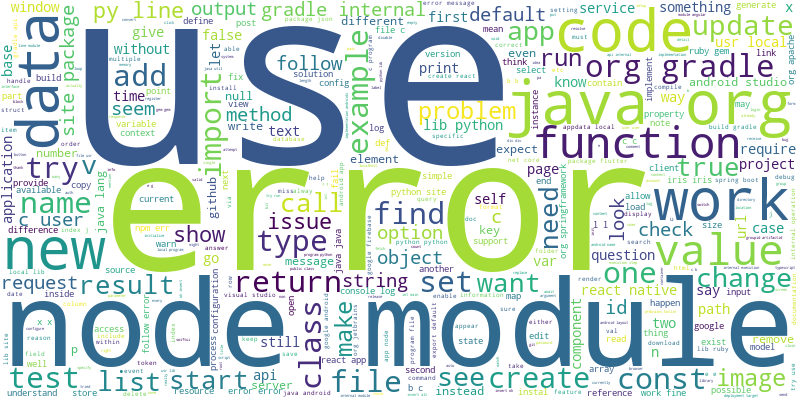

In [10]:
showWordCloud().to_image()

In [11]:
# showWordCloud("python").to_image()

In [12]:
# showWordCloud("pandas").to_image()

In [13]:
# showWordCloud(["python", "pandas"]).to_image()

Number of docs: 92
Tags: ['python', 'pandas']


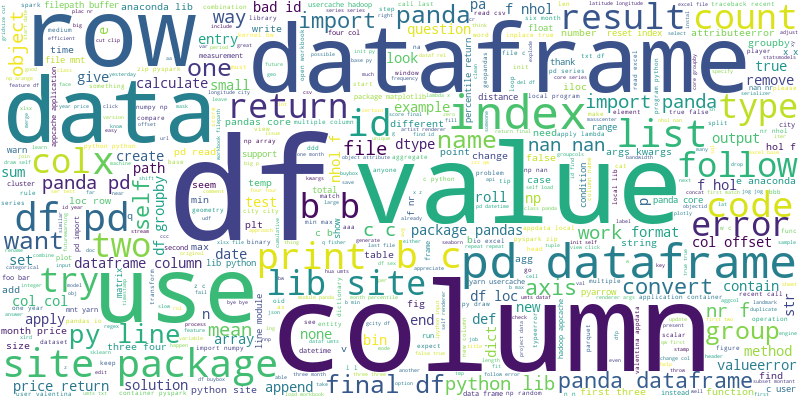

In [14]:
showWordCloud(["python", "pandas"], allTags=True).to_image()

## Preparations données

*Utilisation MultiLabelBinarizer pour filtrer sur les Tags populaires*

In [15]:
# X : le texte (Title+Body, preprocessé)
X = df['Text']

# Y : les tags
# on passe par un MultiLabelBinarizer

Y_allTags = df['Tags_tok']
mlb = MultiLabelBinarizer()
Y_mlb = mlb.fit_transform(Y_allTags)
print(len(mlb.classes_), "tags differents", mlb.classes_)

Y = pd.DataFrame(Y_mlb, index=Y_allTags.index, columns=mlb.classes_)

tags_counts = Y.sum()
# triée pour afficher les 10 + populaires, mais on doit la garder non triée pour pouvoir mapper lors d'inverse_transform
tags_counts.sort_values(ascending=False)[:10]

4356 tags differents ['.htaccess' '.loc' '.net' ... 'zonejs' 'zsh' 'zstack']


python        900
android       795
javascript    713
reactjs       608
c++           588
flutter       468
java          404
ios           370
typescript    349
node.js       347
dtype: int64

In [16]:
tags_counts

.htaccess        2
.loc             1
.net            51
.net-4.7.1       1
.net-4.7.2       1
                ..
zipexception     1
zomato-api       1
zonejs           1
zsh              9
zstack           2
Length: 4356, dtype: int64

In [17]:
def nbTagsPopulaires(seuil):
    return len(tags_counts[tags_counts > seuil])

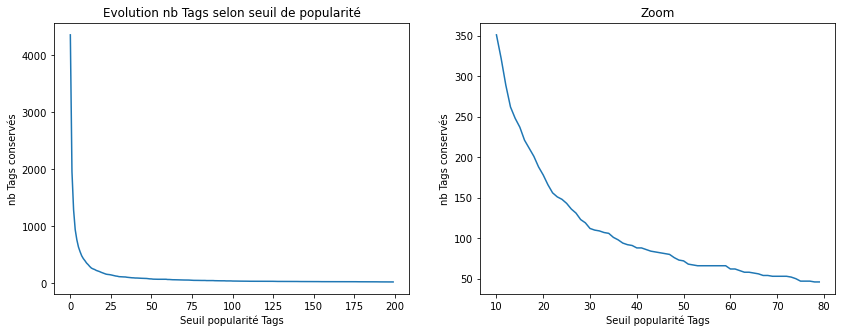

In [18]:
# apercu evolution du nombre de tags selon seuil de popularité (nb d'occurences)
x1 = range(0, 200)
y1 = [nbTagsPopulaires(x) for x in x1]
x2 = range(10, 80)
y2 = [nbTagsPopulaires(x) for x in x2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(x1, y1)
ax1.set_title("Evolution nb Tags selon seuil de popularité")
ax1.set_xlabel("Seuil popularité Tags")
ax1.set_ylabel("nb Tags conservés");
ax2.plot(x2, y2)
ax2.set_title("Zoom")
ax2.set_xlabel("Seuil popularité Tags")
ax2.set_ylabel("nb Tags conservés")

plt.show()

In [19]:
seuil_pop = 30

tags_counts[tags_counts > seuil_pop].sort_values(ascending=False)

python          900
android         795
javascript      713
reactjs         608
c++             588
               ... 
redux            33
.net-5           33
yarnpkg          32
azure-devops     31
regex            31
Length: 112, dtype: int64

### Creation et outils pour ne conserver que les Tags les plus populaires
    question d'efficacité (taille de la matrice) et de problemes liés aux tags inconnus d'un jeu à l'autre
  
    - train_test_split et folds de la cross-validation

- filtre sur les *112* tags populaires retenus (tag count > seuil_pop*=30*)

- on utilise encore le MLB, tant qu'à faire

In [20]:
# le df réduits aux tags populaires uniquement
# need global 'tags_counts'
def reduceMlbToPopular(y_mlb_df, seuil):
    return y_mlb_df.loc[:, (tags_counts > seuil).values.tolist()]

In [21]:
# remet les colonnes impopulaires (les remets vides) pour pouvoir appliquer inverse_transform du MLB
# need global 'tags_counts'
def unPopBack(y, seuil):
    y_0 = np.zeros((y.shape[0], len(tags_counts)), dtype=int)
    y_0[:,(tags_counts > seuil).values.tolist()] = y

    if isinstance(y, pd.Series):
        y_0 = pd.DataFrame(y_0, index=y.index, columns=tags_counts.index)
    return y_0

In [22]:
# inverse_transform 
# need global 'mlb'
def reverse_pop_MLB(y, seuil, index=None):
    y_mlb = unPopBack(y, seuil)
    if isinstance(y, pd.Series):
        y_mlb = y_mlb.values
    tags = mlb.inverse_transform(y_mlb)
    if index is None:
        index_ = y.index
    else:
        index_ = index
    return pd.Series(tags, index=index_).map(np.asarray)

In [23]:
# reverseMLB et concat en DF des tags reel / topPop / predict 
def getResultTags(Y_test, Y_pred, Y_test_allTags, Y_test_popTags, seuil):
    res_pred = reverse_pop_MLB(Y_pred, seuil, index=Y_test.index)
    df_res = pd.concat([Y_test_allTags, Y_test_popTags, res_pred], axis=1, join="inner")
    df_res.columns = ["Full", "reducedPop", "Predicted"]
    return df_res

## MultiOutputClassifier - (SGD, RFC, Perceptron, ...)

In [24]:
def MLBize(Y_tags):
    Y_mlb = mlb.transform(Y_tags)
    return pd.DataFrame(Y_mlb, index=Y_tags.index, columns=mlb.classes_)

In [25]:
def reduceTags(Y_tags, seuil):
    Y_mlb_df = MLBize(Y_tags)
    return reduceMlbToPopular(Y_mlb_df, seuil)

In [26]:
def justPopular(Y, seuil):
    # reduction aux tags populaires
    Y_popTags = reduceMlbToPopular(Y, seuil)
    return reverse_pop_MLB(Y_popTags, seuil)

In [27]:
def customTrainTestSplit(X, Y_popTags, Y_allTags, seuil, random_seed=0, verbose=0):
    
    # split train/test
    X_train, X_test, Y_train_tags, Y_test_tags = train_test_split(X, Y_popTags, random_state=random_seed)

    # MLB sur Y train/test, et reductions aux tags populaires
    Y_train = reduceTags(Y_train_tags, seuil)
    Y_test = reduceTags(Y_test_tags, seuil)

    # SAME split train(unused)/test sur la version avec tout les tags (pour calcul accuracy score vs All)
    _, Y_test_allTags = train_test_split(Y_allTags, random_state=random_seed)
    Y_test_all = MLBize(Y_test_allTags)

    return X_train, X_test, Y_train, Y_test, Y_test_tags, Y_test_allTags, Y_test_all

In [28]:
# verbose : 0 = rien sauf Erreur
#           1 = Classifier et total time
#           2 = Scores
#           3 = fit time par classifier
def trainings(pipes, X_train, X_test, Y_train, Y_test, Y_test_tags, Y_test_allTags, Y_test_all, seuil, verbose=0):
    res = {}
    score_vsPop = {}
    score_vsAll = {}
    t0 = time.time()
    for clf in pipes:

        if verbose > 0:
            print(clf)

        # fit
        tick = time.time()
        try:
            pipes[clf].fit(X_train, Y_train)
        except ValueError:
            print(" !! Erreur: trop de tags, seuil trop bas (on tombe sur des classes vides selon split dans ce cas)")
            res[clf] = None
            score_vsPop[clf] = np.nan
            score_vsAll[clf] = np.nan
            break 
            
        fit_time = time.time() - tick
        
        # predict
        Y_pred = pipes[clf].predict(X_test)

        # score - vs Pop
        score_vsPop[clf] = accuracy_score(Y_test, Y_pred)

        # score - vs All
        # tweak: unPopBack Y_pred pour integrer MLB complet, afin de comparer
        Y_pred_vsAll = unPopBack(Y_pred, seuil)
        score_vsAll[clf] = accuracy_score(Y_test_all, Y_pred_vsAll)

        if verbose > 1:
            print(" Accuracy score vs Popular:", score_vsPop[clf])
            print(" Accuracy score vs All:    ", score_vsAll[clf])
            if verbose > 2:
                print(f" Fit time: {fit_time:.2f} s")
                
        res[clf] = getResultTags(Y_test, Y_pred, Y_test_allTags, Y_test_tags, seuil)
        
    if verbose > 0:
        print(f"Total time: {time.time()-t0:.2f} s")
        print("")
        
    return res, score_vsPop, score_vsAll

In [29]:
def make_cti_pipeline(clf):
    return make_pipeline(CountVectorizer(),TfidfTransformer(),clf)

In [30]:
clfs = {
    'SGD': MultiOutputClassifier(SGDClassifier(max_iter=100)),
    'Perceptron': MultiOutputClassifier(Perceptron()),
    'OvR-LogisticReg': OneVsRestClassifier(LogisticRegression(), n_jobs=-1),  # pas bon, et long
    'RFC-direct': RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)
}
    
pipes = {clf_key: make_cti_pipeline(clfs[clf_key]) for clf_key in clfs}

In [31]:
%%time

res = {}
score_vsPop = {}
score_vsAll = {}
pop_range = range(10, 50, 5)

# log level
loglvl = 3

for seuil in pop_range:
    
    Y_popTags = justPopular(Y, seuil)    
    
    if loglvl > 0:
        print("Seuil =", seuil, " - nb Tags populaires", nbTagsPopulaires(seuil))
        
        
    
    X_train, X_test, Y_train, Y_test, \
    Y_test_tags, Y_test_allTags, Y_test_all = customTrainTestSplit(X, Y_popTags, Y_allTags, seuil=seuil,
                                                                   random_seed=21, verbose=loglvl)

    if loglvl > 1:
        print("")
    
    res[seuil], \
    score_vsPop[seuil], score_vsAll[seuil] = trainings(pipes, X_train, X_test, Y_train, Y_test,
                                                       Y_test_tags, Y_test_allTags, Y_test_all, seuil, verbose=loglvl)

    if loglvl > 1:
        print("--------------------------")


Seuil = 10  - nb Tags populaires 351

SGD
 Accuracy score vs Popular: 0.188800792864222
 Accuracy score vs All:     0.05946481665014866
 Fit time: 4.20 s
Perceptron
 Accuracy score vs Popular: 0.1303270564915758
 Accuracy score vs All:     0.050049554013875126
 Fit time: 3.68 s
OvR-LogisticReg
 Accuracy score vs Popular: 0.08374628344895936
 Accuracy score vs All:     0.02180376610505451
 Fit time: 22.90 s
RFC-direct
 Accuracy score vs Popular: 0.0817641228939544
 Accuracy score vs All:     0.01684836471754212
 Fit time: 2.67 s
Total time: 36.80 s

--------------------------
Seuil = 15  - nb Tags populaires 237

SGD
 Accuracy score vs Popular: 0.2254707631318137
 Accuracy score vs All:     0.0599603567888999
 Fit time: 3.08 s
Perceptron
 Accuracy score vs Popular: 0.16501486620416253
 Accuracy score vs All:     0.05153617443012884
 Fit time: 2.62 s
OvR-LogisticReg
 Accuracy score vs Popular: 0.11050545094152626
 Accuracy score vs All:     0.02180376610505451
 Fit time: 15.70 s
RFC-dire

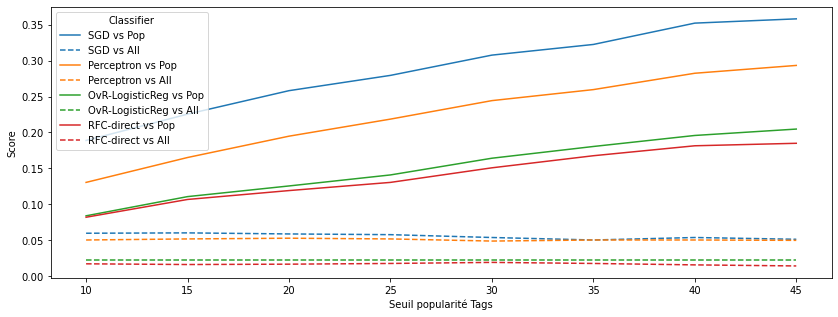

In [32]:
fig, ax = plt.subplots(figsize=(14, 5))
for i, clf in enumerate(clfs):
    y1 = [score_vsPop[s][clf] for s in pop_range]
    y2 = [score_vsAll[s][clf] for s in pop_range]
    ax.plot(pop_range, y1, c='C'+str(i), label=str(clf)+" vs Pop")
    ax.plot(pop_range, y2, c='C'+str(i), label=str(clf)+" vs All", ls='--')
    # ax.set_title("Scores")
    ax.set_xlabel("Seuil popularité Tags")
    ax.set_ylabel("Score")
plt.legend(title='Classifier')
plt.show()


In [33]:
# seuil = 15
# si commenté, seuil = le dernier de pop_range

for clf in clfs:
    print("Classifier:", clf, "- Seuil:", seuil)
    print("Score vs Pop:", score_vsPop[seuil][clf])
    print("Score vs All:", score_vsAll[seuil][clf])
    display(res[seuil][clf])

Classifier: SGD - Seuil: 45
Score vs Pop: 0.3582755203171457
Score vs All: 0.051040634291377604


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],[visual-studio]
1969,"[python, pandas, dataframe]","[pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#]","[.net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: Perceptron - Seuil: 45
Score vs Pop: 0.2933597621407334
Score vs All: 0.049554013875123884


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],"[visual-studio, visual-studio-code, windows-su..."
1969,"[python, pandas, dataframe]","[pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#]","[c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js]",[eslint]
5353,"[java, android, firebase]","[android, firebase, java]",[firebase]
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: OvR-LogisticReg - Seuil: 45
Score vs Pop: 0.20465807730426164
Score vs All: 0.02180376610505451


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],[]
1969,"[python, pandas, dataframe]","[pandas, python]",[python]
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#]","[.net-core, c#]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js]",[]
5353,"[java, android, firebase]","[android, firebase, java]",[android]
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]",[python]


Classifier: RFC-direct - Seuil: 45
Score vs Pop: 0.18483647175421208
Score vs All: 0.013875123885034688


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],[]
1969,"[python, pandas, dataframe]","[pandas, python]",[python]
4327,"[android, file, storage, android-external-stor...",[android],[]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#]",[c#]
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js]",[]
5353,"[java, android, firebase]","[android, firebase, java]",[android]
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]",[python]


In [34]:
clf = 'SGD'

for seuil in pop_range:
    print("Classifier:", clf, "- Seuil:", seuil)
    print("Score vs Pop:", score_vsPop[seuil][clf])
    print("Score vs All:", score_vsAll[seuil][clf])
    display(res[seuil][clf])

Classifier: SGD - Seuil: 10
Score vs Pop: 0.188800792864222
Score vs All: 0.05946481665014866


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],"[visual-studio, visual-studio-2019]"
1969,"[python, pandas, dataframe]","[dataframe, pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...","[android, file]",[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#, visual-studio-2019]","[.net-5, .net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, node-modules, vue.js, yarnpkg]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: SGD - Seuil: 15
Score vs Pop: 0.2254707631318137
Score vs All: 0.0599603567888999


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[android]
7332,[visual-studio],[visual-studio],"[visual-studio, visual-studio-2019]"
1969,"[python, pandas, dataframe]","[dataframe, pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#, visual-studio-2019]","[.net-5, .net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, node-modules, vue.js, yarnpkg]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: SGD - Seuil: 20
Score vs Pop: 0.2581764122893954
Score vs All: 0.05847373637264618


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],"[visual-studio, visual-studio-2019]"
1969,"[python, pandas, dataframe]","[dataframe, pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#, visual-studio-2019]","[.net-5, .net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js, yarnpkg]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: SGD - Seuil: 25
Score vs Pop: 0.2794846382556987
Score vs All: 0.057482656095143705


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],"[visual-studio, visual-studio-2019]"
1969,"[python, pandas, dataframe]","[dataframe, pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#, visual-studio-2019]","[.net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js, yarnpkg]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: SGD - Seuil: 30
Score vs Pop: 0.30773042616451934
Score vs All: 0.053518334985133795


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],"[visual-studio, visual-studio-2019]"
1969,"[python, pandas, dataframe]","[dataframe, pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#, visual-studio-2019]","[.net-5, .net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js, yarnpkg]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: SGD - Seuil: 35
Score vs Pop: 0.3225966303270565
Score vs All: 0.050049554013875126


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],"[visual-studio, visual-studio-2019]"
1969,"[python, pandas, dataframe]","[dataframe, pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#, visual-studio-2019]","[.net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: SGD - Seuil: 40
Score vs Pop: 0.35232903865213083
Score vs All: 0.053518334985133795


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],[visual-studio]
1969,"[python, pandas, dataframe]","[dataframe, pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#]","[.net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


Classifier: SGD - Seuil: 45
Score vs Pop: 0.3582755203171457
Score vs All: 0.051040634291377604


,Full,reducedPop,Predicted
752,"[android, android-app-signing]",[android],[]
7332,[visual-studio],[visual-studio],[visual-studio]
1969,"[python, pandas, dataframe]","[pandas, python]","[pandas, python]"
4327,"[android, file, storage, android-external-stor...",[android],[android]
603,"[c#, .net, visual-studio-2019, class-library]","[.net, c#]","[.net-core, c#, visual-studio]"
...,...,...,...
1247,"[javascript, performance-testing, chromium, v8]",[javascript],[javascript]
8035,"[vue.js, node-modules, eslint, yarnpkg, vue-cli]","[eslint, vue.js]","[eslint, vue.js]"
5353,"[java, android, firebase]","[android, firebase, java]","[android, firebase]"
6109,"[python, pandas, parquet, pyarrow, fastparquet]","[pandas, python]","[pandas, python]"


## Visualisation du Nombre de Questions avec N tags selon seuil

En effet, si le score augmente avec le seuil, on a de plus en plus de questions sans tags (pour l'apprentissage),
ce qui certes donne un bon score (vs Pop) mais diminue le score vsAll, et en tout état de cause ne prédit plus grand chose à force

In [35]:
def get_nbQwithNTags(Y, range_seuil):
    return pd.concat([pd.DataFrame(justPopular(Y, seuil).map(len).value_counts().sort_index(), columns=[seuil]) 
               for seuil in range_seuil], axis=1).fillna(0)

In [36]:
%%time

range_seuil = range(0, 100, 5)
info = get_nbQwithNTags(Y, range_seuil)

Wall time: 12.6 s


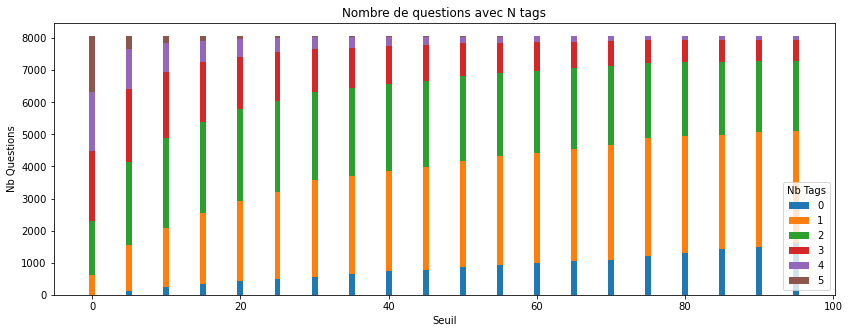

In [37]:
fig, ax = plt.subplots(figsize=(14, 5))
bottom_sum = np.zeros(len(range_seuil))
for idx in info.index:
    if max(bottom_sum) == 0:
        ax.bar(range_seuil,info.loc[idx, :], label=idx)
    else:
        ax.bar(range_seuil,info.loc[idx, :], bottom=bottom_sum, label=idx)
    bottom_sum+=info.loc[idx, :]
ax.set_xlabel("Seuil")
ax.set_ylabel("Nb Questions")
plt.title("Nombre de questions avec N tags")
plt.legend(title="Nb Tags", loc="lower right")
plt.show()

In [38]:
# Hyper parametrage de pipeline X Y
# /!!!! Ca marche pas, en tout cas pour SGDClassifier,
#       car on n'applique pas le MLB a chaque fold de la cross validation, du coup on a des fold avec des tags vides
#       (tous False alors qu'on devrait avoir Y.nunique() == [True, False])
#       -> ValueError: The number of classes has to be greater than one; got 1 class
clfs = {
    'SGD': MultiOutputClassifier(SGDClassifier()),
    'Perceptron': MultiOutputClassifier(Perceptron()),
    'OvR-LogisticReg': OneVsRestClassifier(LogisticRegression(), n_jobs=-1),  # pas bon, et long
    'RFC-direct': RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'GNB': MultiOutputClassifier(GaussianNB())
}
    
pipesHP = {clf_key: make_cti_pipeline(clfs[clf_key]) for clf_key in clfs}


parameters_1 = {
    "countvectorizer__max_df": (0.5, 0.75, 1.0),
    'countvectorizer__max_features': (None, 5000, 10000, 50000),
    "countvectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidftransformer__use_idf': (True, False),
    'tfidftransformer__norm': ('l1', 'l2'),
    # 'clf__max_iter': (10, 50, 80),
}
parameters = {
    "countvectorizer__max_df": (0.5,),
    'countvectorizer__max_features': (10000,),
    "countvectorizer__ngram_range": ((1, 1), (1, 2),(1, 3),),  # unigrams or bigrams or trigrams
    'tfidftransformer__use_idf': (True,),
    'tfidftransformer__norm': ('l2',),
    'multioutputclassifier__estimator__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',),
                                     #          'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
    'multioutputclassifier__estimator__penalty': ('l1','l2'),   # ('l2', 'l1', 'elasticnet'),
    'multioutputclassifier__estimator__alpha': (1e-5,),  # 1e-3, 1e-1),
    'multioutputclassifier__estimator__max_iter': (100, 500, 1000)         # (100, 500, 1000)
}
parameters_min = {
    "countvectorizer__max_df": (0.5,),
    'countvectorizer__max_features': (10000,),
    "countvectorizer__ngram_range": ((1, 3),),  # unigrams or bigrams or trigrams
    'tfidftransformer__use_idf': (True,),
    'tfidftransformer__norm': ('l2',),
}


Y_forGrid = reduceTags(Y_popTags, seuil=45)

if __name__ == "__main__":
    
    pipeline = pipesHP['SGD']
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # grid_search = GridSearchCV(pipeline, parameters, cv=StratifiedKFold(shuffle=False), n_jobs=-1, verbose=1)
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print(grid_search)


    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search.fit(X, Y_forGrid)
    print("done in %0.3fs" % (time.time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        


GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('tfidftransformer', TfidfTransformer()),
                                       ('multioutputclassifier',
                                        MultiOutputClassifier(estimator=SGDClassifier()))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': (0.5,),
                         'countvectorizer__max_features': (10000,),
                         'countvectorizer__ngram_range': ((1, 1), (1, 2),
                                                          (1, 3)),
                         'multioutputclassifier__estimator__alpha': (1e-05,),
                         'multioutputclassifier__estimator__loss': ('hinge',
                                                                    'log',
                                                                    'modified_huber',
                                                                    'squa

In [39]:
MultiOutputClassifier(estimator=Perceptron()).get_params().keys()

dict_keys(['estimator__alpha', 'estimator__class_weight', 'estimator__early_stopping', 'estimator__eta0', 'estimator__fit_intercept', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__n_iter_no_change', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__shuffle', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [40]:
grid_search.cv_results_

{'mean_fit_time': array([ 7.59716272,  5.04879069,  7.58656359,  4.9611289 ,  7.83736372,
         5.07294235,  8.36808276,  4.52501855,  8.08243775,  4.42100439,
         8.12835107,  4.52393064,  8.8186285 ,  4.85686665,  9.07268386,
         5.04331951,  9.1076529 ,  5.11635346,  9.90073643,  7.58551569,
        11.30486999,  7.25435815, 11.02814989,  7.0459847 ,  7.16961527,
         4.44900355,  7.1511332 ,  4.3300993 ,  7.19194322,  4.60303664,
        13.85391884, 10.68100605, 13.58154621, 11.13407888, 14.15001607,
        10.82523923, 14.00278864, 10.25673089, 14.00195708, 10.04226298,
        13.98434906, 10.07886744, 14.53575983, 10.9382236 , 15.14035144,
        10.96567612, 14.91071506, 10.8751606 , 15.22558718, 13.15332456,
        16.38102956, 13.19379134, 15.45713506, 14.30767517, 12.85251827,
        10.29912558, 12.83893452, 10.47479758, 12.77482529, 10.18983927,
        22.1686358 , 18.82867494, 21.2542469 , 19.34813094, 22.4513948 ,
        18.94829898, 22.12493911, 

In [41]:
best_model = grid_search.best_estimator_
choosen_seuil = 45

In [42]:
Y_pred = best_model.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=tags_counts[tags_counts > 45].index))

                             precision    recall  f1-score   support

                       .net       1.00      1.00      1.00        15
                  .net-core       0.84      1.00      0.91        16
                  algorithm       1.00      1.00      1.00        12
        amazon-web-services       1.00      1.00      1.00        30
                    android       1.00      1.00      1.00       208
    android-jetpack-compose       1.00      1.00      1.00        23
             android-studio       0.97      0.93      0.95        61
                    angular       0.97      1.00      0.99        67
                     arrays       1.00      0.94      0.97        16
               asp.net-core       0.95      0.87      0.91        23
                     blazor       1.00      1.00      1.00        12
                          c       1.00      0.97      0.98        30
                         c#       0.97      1.00      0.99        68
                        c++      

C:\Users\beb4e\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beb4e\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
Y_pred = best_model.predict(X_test)
Y_mlb_pred = unPopBack(Y_pred, choosen_seuil)
Y_mlb_test = unPopBack(Y_test, choosen_seuil)
print(classification_report(Y_mlb_test, Y_mlb_pred, target_names=tags_counts.index))

                                     precision    recall  f1-score   support

                          .htaccess       0.00      0.00      0.00         0
                               .loc       0.00      0.00      0.00         0
                               .net       1.00      1.00      1.00        15
                         .net-4.7.1       0.00      0.00      0.00         0
                         .net-4.7.2       0.00      0.00      0.00         0
                             .net-5       0.00      0.00      0.00         0
                           .net-6.0       0.00      0.00      0.00         0
                          .net-core       0.84      1.00      0.91        16
                      .net-core-2.2       0.00      0.00      0.00         0
                      .net-core-3.0       0.00      0.00      0.00         0
                      .net-core-3.1       0.00      0.00      0.00         0
        .net-core-publishsinglefile       0.00      0.00      0.00         

C:\Users\beb4e\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beb4e\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beb4e\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beb4e\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [44]:
# Test sur une nouvelle question

my_pred = best_model.predict(["problem with convert array to string in python"])
res_mlb = unPopBack(my_pred, choosen_seuil)
res = mlb.inverse_transform(res_mlb)
res

[('arrays', 'python')]

In [45]:
import pickle

# sauvegarder notre modèle et mlb
pickle.dump(best_model ,open('new_model.pkl','wb'))
pickle.dump(mlb ,open('mlb.pkl','wb'))

unpop_info = {
    'seuil': choosen_seuil,
    'tags_counts': tags_counts
}
# trucs necessaires pour l'inverse du MLB
pickle.dump(unpop_info ,open('unpop_info.pkl','wb'))

### Anciens resultats GridSearch